# ECoG Spectrogram Forecasting with Sequence-to-Sequence (seq2seq) RNN models.

## Starting small: 1 channel.

In [1]:
#!/usr/bin/env python
# coding: utf-8

from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training, Encoder, Decoder, Seq2Seq, Util

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split
from torch.nn.modules.loss import _Loss
from torch.nn.functional import mse_loss

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

# import progressbar as pb
import datetime
import os
import sys
import pickle as pkl

import argparse
import matplotlib.pyplot as plt

# modules that aren't done yet
# sys.path.append('/Users/mickey/aoLab/code/analyze/')
sys.path.append('/home/mickey/analyze/')
from tfspec import tfspec

The code in the next cell is used to parse command line arguments. These arguments assign values to the network and training parameters. This functionality has been replaced with more hard-coded constants in the current notebook. From an organizational standpoint, that's not the worst thing - it's given me a good opportunity to collect all of the constants together into one single code block @ the top of the notebook. They were pretty scattershot before that.

In [2]:
# # grab input arguments
# parser = argparse.ArgumentParser('Trains a seq2seq network on a section of example NHP PMC ECoG data.',add_help=True)
# parser.add_argument('--encoder-depth', metavar='el', type=int, default=10, help='Sequence depth of the encoder network')
# parser.add_argument('--decoder-depth', metavar='dl', type=int, default=1, help='Sequence depth of the decoder network')
# parser.add_argument('--batch-size', metavar='b', type=int, default=1, help='Data batch size')
# parser.add_argument('--num-epochs', metavar='n', type=int, default=1, help='Number of optimization epochs')
# parser.add_argument('--num-layers', metavar='nl', type=int, default=1, help='Number of layers in each RNN block')

# args = parser.parse_args() # this bad boy has all the values packed into it. Nice!
# print(args.encoder_depth,args.decoder_depth)

# print(args.encoder_depth,args.decoder_depth)

In [24]:
# define constants
T_MINUTES = 40
ENCODER_DEPTH = 30
DECODER_DEPTH = 30
BATCH_SIZE = 100
NUM_EPOCHS = 500
N_EPOCHS = NUM_EPOCHS
RNG_SEED = 5050
INPUT_SEQ_LEN = ENCODER_DEPTH
OUTPUT_SEQ_LEN = DECODER_DEPTH
N_CH_USE = 1
N_LAYER = 1
DROPOUT = np.float32(0.3)
ENC_DROPOUT = np.float32(DROPOUT)
DEC_DROPOUT = np.float32(DROPOUT)
LEARN_RATE = 0.001 # default ADAM: 0.001
LOSS_OBJ = 'MSE' #L1, L2, see training.py:ECOGLoss()
WEIGHT_RANGE = (-0.2,0.2) # ignore for now; not sure how to worm this through
train_frac = 0.5
test_frac = 0.5
valid_frac = 0.0
# BATCH_SIZE = args.batch_size
# N_EPOCHS = args.num_epochs
CLIP = 1. # this the maximum norm of the whole parameter gradient.
TFR = 0.0 # no teacher forcing! Anything it's learning is all on its own
RAND_SAMP = False
weight_reg = 0.#0.0003
enc_len = ENCODER_DEPTH
dec_len = DECODER_DEPTH
seq_len = ENCODER_DEPTH+DECODER_DEPTH # use ten time points to predict the next time point

In [25]:
# seed RNG for pytorch/np
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
torch.cuda.manual_seed(RNG_SEED)
torch.backends.cudnn.deterministic = True # enforces deterministic algorithm use -> reproducibility. Remove for production code. You don't do production code. Don't remove.

In [26]:
# set device - CUDA if you've got it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('mounting to device: {}'.format(device))

mounting to device: cuda


In [27]:
# load data
platform_name = sys.platform
if platform_name == 'darwin':
    # local machine
    data_file_full_path = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.lfp.dat'
    mask_file_path = "/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
    model_save_dir_path = '/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq/'
elif platform_name == 'linux2':
    # HYAK, baby!
    data_file_full_path = '/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = "/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
elif platform_name == 'linux':
    # google cloud, don't fail me now
    data_file_full_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.mask.pkl'
    model_save_dir_path = '/home/mickey/models/pyt/seq2seq/'

# make sure the output directory actually exists
if not os.path.exists(model_save_dir_path):
    os.makedirs(model_save_dir_path)

data_in, data_param, data_mask = datareader.load_ecog_clfp_data(data_file_name=data_file_full_path)
srate_in = data_param['srate']
num_ch = data_param['num_ch']

Loading data file:


In [28]:
# mask data array, remove obvious outliers
# data_in[:,np.logical_or(data_mask["hf"],data_mask["sat"])] = 0.

# downsample data
srate_down = 250
srate = srate_in

# grab local time segment
total_len_T = T_MINUTES*60
total_len_n = total_len_T*srate_in
# data_idx = data_in.shape[1]//2 + np.arange(total_len_n)
print('Downsampling data from {0} to {1}'.format(srate_in,srate_down))
### note: this breaks mask indexing, if you plan to do that later.
data_in = np.float32(sp.signal.decimate(data_in[:N_CH_USE,:],srate_in//srate_down,axis=-1))
data_in = np.float32(data_in[:N_CH_USE,:])
data_in = data_in*1e-3 # convert to mV
print('Data Size:\t{}\n'.format(data_in.shape))

# # filter dead channels
# ch_rms = np.std(data_in,axis=-1)
# ch_m = np.mean(ch_rms)
# ch_low_lim = ch_m - 2*np.std(ch_rms)
# ch_up_lim = ch_m + 2*np.std(ch_rms)
# ch_idx = np.logical_and(ch_rms > ch_low_lim, ch_rms < ch_up_lim)
# ch_list = np.arange(num_ch)[ch_idx]
# num_ch_down = len(ch_list)
# print('Filtering Channels:')
# print('Num. ch. used:\t{}'.format(num_ch_down))
# print('Ch. kept:\t{}\n'.format(ch_list))

Downsampling data from 1000 to 250
Data Size:	(1, 1801794)



In [9]:
# compute data spectrogram
tapers = [4,1];
dn = 0.5;
# T = 60
sgram, f_sgram, ti, err = tfspec(data_in, tapers=tapers, sampling=srate_down, dn=dn,fk=(0,120), contflag=False);
t_sgram = ti/srate_down

['Using ', [4, 4, 7], ' tapers.']


In [10]:
# filter bad regions by spectrogram power
print('Detecting bad spectrogram regions')
db_power = np.clip(10*np.ma.log10(sgram).mean(axis=-1)[0,:],a_min=-50,a_max=np.inf)
db_power_mean = db_power.mean()
db_power_std = db_power.std()
std_k = 0.25
bad_sgram_idx = (db_power.data < db_power_mean - 3*std_k*db_power_std) | \
                (db_power.data > db_power_mean + std_k*db_power_std) | \
                (db_power.mask)
print('{}% retained'.format(100-bad_sgram_idx.mean()*100))

Detecting bad spectrogram regions
87.17895321393864% retained


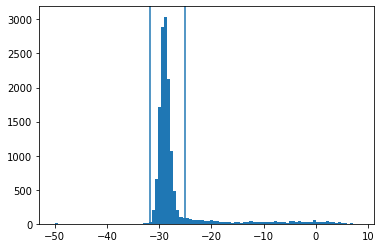

In [11]:
plt.hist(db_power,100)
plt.axvline(db_power_mean - 3*std_k*db_power_std)
plt.axvline(db_power_mean + std_k*db_power_std)

In [12]:
# define function for spectrogram plotting; forgive the misnomer
def plot_log_psd(ax,psd,x,y,clim,cmap='viridis',cb_label='dB'):
    # create norm from clim
    norm = plt.Normalize(vmin=clim[0],vmax=clim[1])
    # get axes extent from x, y
    extent = (x.min(), x.max(), y.min(), y.max())
    # plot the figure
    im_h = ax.imshow(10*np.log10(psd),extent=extent,norm=norm,origin='bottom',aspect='auto')
    # add a colorbar
    cb_h = plt.colorbar(im_h, ax=ax, label=cb_label, pad=0.01)
    
    return im_h, cb_h

In [13]:
# define function for spectrogram plotting; forgive the misnomer
def plot_psd(ax,psd,x,y,clim,cmap='viridis',cb_label='power'):
    # create norm from clim
    norm = plt.Normalize(vmin=clim[0],vmax=clim[1])
    # get axes extent from x, y
    extent = (x.min(), x.max(), y.min(), y.max())
    # plot the figure
    im_h = ax.imshow(psd,extent=extent,norm=norm,origin='bottom',aspect='auto')
    # add a colorbar
    cb_h = plt.colorbar(im_h, ax=ax, label=cb_label, pad=0.01)
    
    return im_h, cb_h

Text(0.5, 0, 'time (s)')

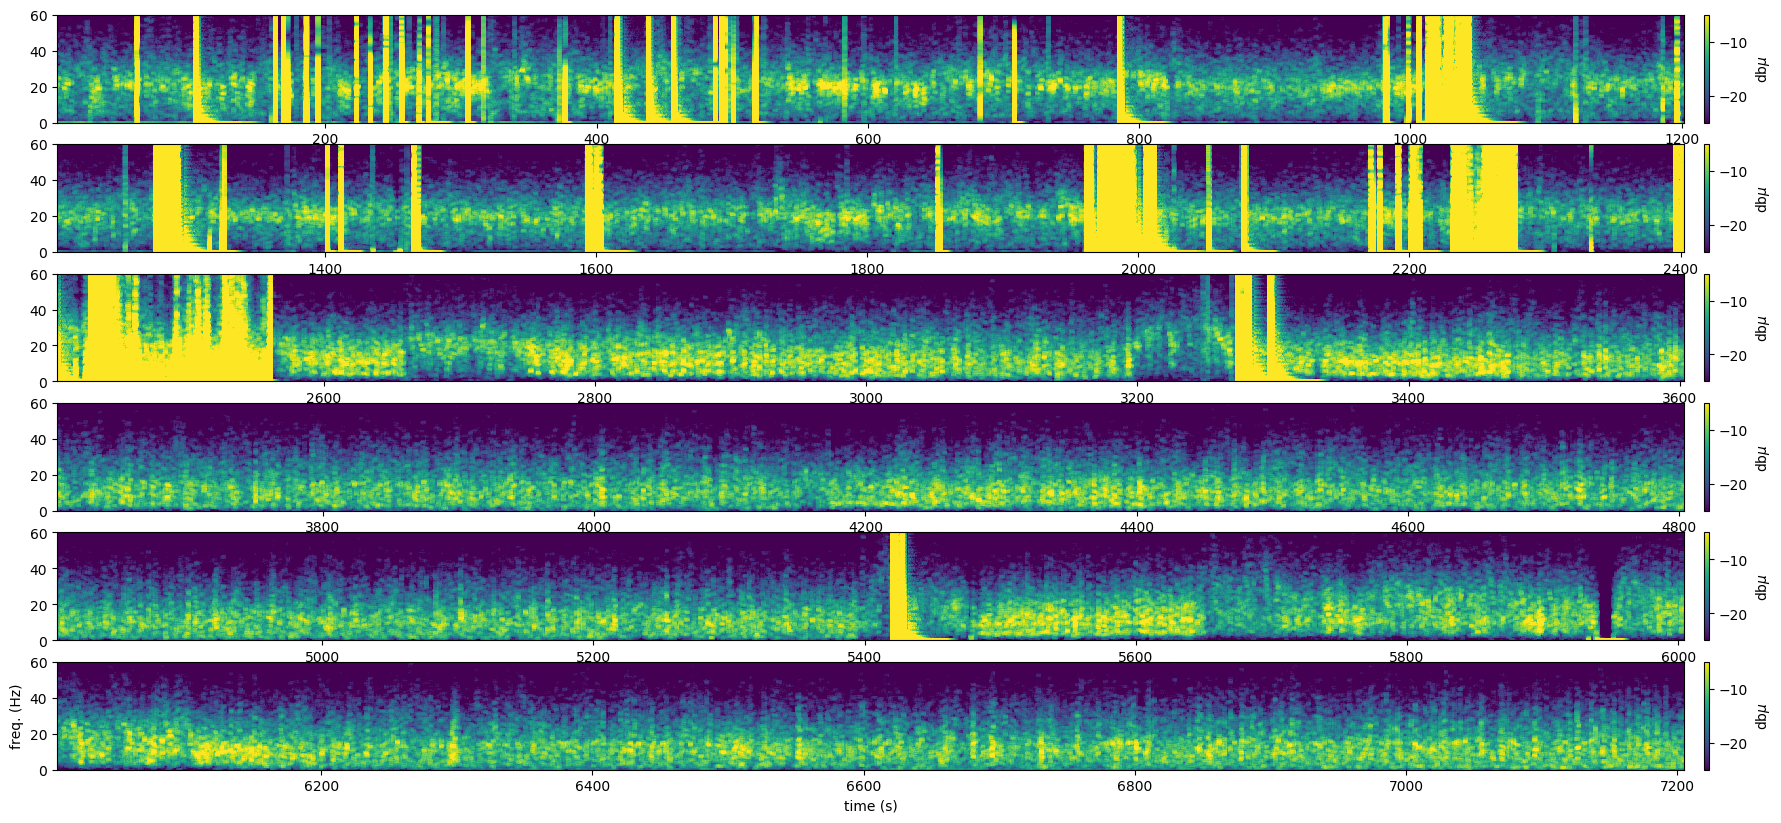

In [14]:
n_col = 6
f,ax = plt.subplots(n_col,1,figsize=(25,10),dpi=100)
n_win = sgram.shape[1]
n_win_per_row = n_win//n_col
clim = (-25,-5)
for k in range(n_col):
    plot_idx = np.arange(k*n_win_per_row,(k+1)*n_win_per_row)
    plot_log_psd(ax[k],sgram[:,plot_idx,].mean(axis=0).T,t_sgram[plot_idx],f_sgram,clim,cb_label='db$\mu$')
    ax[k].set_ylim(0,60)
ax[-1].set_ylabel('freq. (Hz)')
ax[-1].set_xlabel('time (s)')

## Creating a dataset/tensor from the spectrogram data
Spectrogram data is a $n_{ch}\times n_{win}\times n_{freq}$ array, so creating a pytorch tensor, dataset and loader from a spectrogram is not very complicated. However, doing that in a way that plays well nicely with recurrent neural network models is less straightforward, primarily because of the variability in frequency band power across the spectrogram and the requirement of normalized data inputs.

How should I do this? It's an open question for me, but some paper probably has the answer.

In [15]:
# create dataset
#create data tensor
print('Normalizing data, converting to tensor:')
data_rail = np.max(np.abs(data_in.reshape(-1)))
# normalization = 'zscore'
# normalization = 'tanh'
# if normalization is 'max':
#     data_tensor = torch.from_numpy(data_in.view().T/data_rail)
# elif normalization is 'zscore':
#     # for nominally gaussian data distributions, this will get ~99% of data points in (-1, 1)
#     data_tensor = torch.from_numpy(sp.stats.zscore(data_in.view().T)/5)
# elif normalization is 'tanh':
#     data_tensor = torch.from_numpy(np.tanh(sp.stats.zscore(data_in.view().T)/3))
# print('Data tensor shape: {}\n'.format(data_tensor.shape))
N_FREQ_BINS = -1
n_sgram_win = sgram.shape[-1]
freq_range = (1, 80)
freq_idx = (f_sgram >= freq_range[0]) & (f_sgram <= freq_range[1])
mean_sgram = np.log10(sgram[0,~bad_sgram_idx,:]).mean(axis=0)
log_sgram_ceil = np.log10(sgram[0,~bad_sgram_idx,:])[:,freq_idx].max()
log_sgram_floor = np.log10(sgram[0,~bad_sgram_idx,:])[:,freq_idx].min()
log_sgram_mid = (log_sgram_ceil + log_sgram_floor)/2
log_sgram_range = log_sgram_ceil - log_sgram_floor
# PCA_REDUCE = False
NORMALIZE_DATA = True
if NORMALIZE_DATA:
#     data_array = ((np.log10(sgram[0,])-log_sgram_mid)/log_sgram_range*1.8)[:,freq_idx]
    mean_psd = sgram.mean(axis=(0,1))
    data_array = sp.stats.zscore(np.log10(sgram),axis=(0,1))[0,]
else:
    data_array = np.log10(sgram[0,:,freq_idx]).T
# if PCA_REDUCE:
#     k = 6
#     data_cov = np.cov(data_array[np.logical_not(bad_sgram_idx),:].T)
#     data_cov_eigval, data_cov_eigvec = np.linalg.eig(data_cov)
#     data_tensor = torch.from_numpy(data_array.dot(data_cov_eigvec[:,:k]))
data_tensor = torch.from_numpy(np.float32(data_array))

Normalizing data, converting to tensor:


In [16]:
# create dataset object
print('Creating EcogDataloader dataset object:')
if device == 'cuda:0':
    data_tensor.cuda()
dataset = EcogDataloader.EcogDataset(data_tensor,device,seq_len) ## make my own Dataset class
num_ch_down = dataset.n_ch
print('\n')

Creating EcogDataloader dataset object:




In [17]:
# generate sampling index sets
# avoid all windows that contain a zero-value (the log power will die here)
# dataset_power_sum = dataset.data.sum(axis=-1)
# inf_power_idx = np.isinf(dataset_power_sum)
# dataset_mean = dataset_power_sum[np.logical_not(inf_power_idx)].numpy().mean()
# dataset_std = dataset_power_sum[np.logical_not(inf_power_idx)].numpy().std()
# power_upper_limit = dataset_mean + 3*dataset_std
# power_lower_limit = dataset_mean - 3*dataset_std
# dataset_mask = np.logical_or(dataset_power_sum <= power_lower_limit
#                             ,dataset_power_sum >= power_upper_limit).numpy() # "are you outside the limits"
idx_all = np.arange(dataset.data.shape[0])
idx_step = DECODER_DEPTH
sample_idx = idx_all[:-seq_len:idx_step]
n_win = sample_idx.shape[0]
idx_cut = np.zeros((n_win),dtype=bool)
for k in range(n_win):
    idx_cut[k] = np.any(bad_sgram_idx[sample_idx[k]:(sample_idx[k]+seq_len)])
sample_idx = sample_idx[np.logical_not(idx_cut)]
# plot samples
n_plot_seed = 1
n_plot_step = 4*seq_len
plot_seed_idx = np.arange(0,n_plot_seed*n_plot_step,n_plot_step)

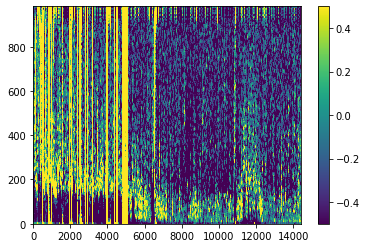

In [18]:
plt.imshow(dataset.data.T,clim=(-0.5,0.5),aspect='auto',origin='bottom')
plt.colorbar()

In [19]:
# define the network!
n_win, n_freq = dataset.data.shape
INPUT_DIM = n_freq
OUTPUT_DIM = n_freq
HID_DIM = 2**12

# enc = Encoder.Encoder_GRU(INPUT_DIM, HID_DIM, N_ENC_LAYERS, INPUT_SEQ_LEN, ENC_DROPOUT)
# dec = Decoder.Decoder_GRU(OUTPUT_DIM, HID_DIM, N_DEC_LAYERS, OUTPUT_SEQ_LEN, DEC_DROPOUT)

model = Seq2Seq.Seq2Seq_GRU(INPUT_DIM, HID_DIM, N_LAYER, ENCODER_DEPTH, DECODER_DEPTH, device, dropout=DROPOUT).to(device)
model.apply(Util.init_weights) # initialize the model each time.

print(f'The model has {Util.count_parameters(model):,} trainable parameters')

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(),lr=LEARN_RATE/10.,weight_decay=weight_reg)

/home/mickey/miniconda3/envs/ecog_is2s/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


The model has 128,898,007 trainable parameters


In [20]:
print(n_win, n_freq)
print(model)

14406 983
Seq2Seq_GRU(
  (encoder): Encoder_GRU(
    (rnn): GRU(983, 4096, batch_first=True, dropout=0.5)
  )
  (decoder): Decoder_GRU(
    (rnn): GRU(983, 4096, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc_out): Linear(in_features=4096, out_features=983, bias=True)
  )
)


In [21]:
# simple progressbar, not tied to the iterator
def print_progress_bar(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

Text(0.5, 1.0, 'Prediction')

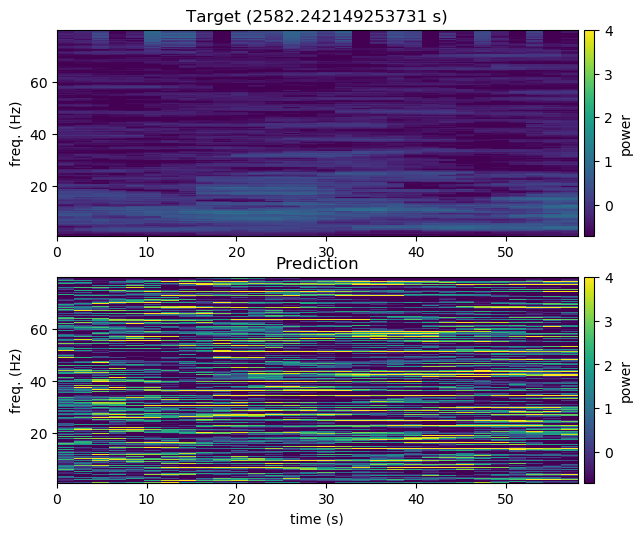

In [22]:
# look at model outputs when initialized
from mpl_toolkits.axes_grid1 import make_axes_locatable
win_t = 2*np.arange(DECODER_DEPTH)
f_pred,ax = plt.subplots(2,1,figsize=(8,6),dpi=100)
# for sidx in sample_idx:
sidx = sample_idx[51]
t_pred = t_sgram[sidx]
seq_test = dataset.__getitem__(sidx)
src_test = seq_test[:ENCODER_DEPTH].unsqueeze(0)
trg_test = seq_test[ENCODER_DEPTH:].unsqueeze(0)
pred_test = model(src_test,trg_test)
criterion(trg_test,pred_test[0])
plot_psd(ax[0],trg_test[0,:,:].cpu().T,win_t,f_sgram[freq_idx],[-0.7,4])
plot_psd(ax[1],pred_test[0][0,:,:].cpu().detach().numpy().T,win_t,f_sgram[freq_idx],[-0.7,4])
ax[0].set_ylabel('freq. (Hz)')
ax[0].set_title('Target ({} s)'.format(t_pred))
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('freq. (Hz)')
ax[1].set_title('Prediction')

saving session data to:	/home/mickey/models/pyt/seq2seq/enc30_dec30_nl2_nep500_20200708063104966460


KeyboardInterrupt: 

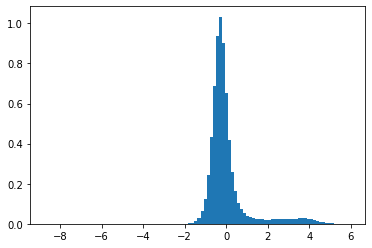

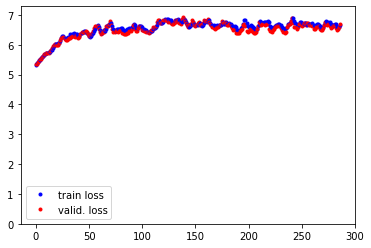

In [23]:
# train/test!
best_test_loss = float('inf')

train_loss = np.zeros(N_EPOCHS)
train_batch_loss = []
test_loss = np.zeros(N_EPOCHS)
test_batch_loss = []
print_train_loss = np.Inf
print_test_loss = np.Inf

# create training session directory
time_str = Util.time_str() # I may do well to pack this into util
session_save_path = os.path.join(model_save_dir_path,'enc{}_dec{}_nl{}_nep{}_{}'.format(enc_len,dec_len,N_ENC_LAYERS,N_EPOCHS,time_str))
sequence_plot_path = os.path.join(session_save_path,'example_sequence_figs')
os.makedirs(session_save_path) # no need to check; there's no way it exists yet.
os.makedirs(sequence_plot_path)
print('saving session data to:\t{}'.format(session_save_path))
# save a histogram of the data distribution; allowing you to check
f,ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(dataset.data.reshape(-1),100,density=True)
f.savefig(os.path.join(session_save_path,'norm_data_hist.png'))

# make figure (and a place to save it)
f_loss = plt.figure()
ax_loss = f_loss.add_subplot(1,1,1)

for e_idx, epoch in enumerate(range(N_EPOCHS)):
    print_progress_bar(epoch,N_EPOCHS,status='epoch: {}\ttrain loss: {}\tvalid loss:{}'.format(epoch,print_train_loss,print_test_loss))

    start_time = time.time()

    # get new train/test splits
    # note: add switch to genLoaders to allow for fixed/random sampling
    train_loader, test_loader, _, plot_loader = EcogDataloader.genLoaders(dataset, sample_idx, train_frac
                                                                          , test_frac, valid_frac, BATCH_SIZE
                                                                          , rand_samp=RAND_SAMP, plot_seed=plot_seed_idx)
#     print('Training Network:')
    _, trbl_ = model.train_iter(train_loader, optimizer, criterion, CLIP, TFR)
    train_batch_loss.append(trbl_)
    train_loss[e_idx] = np.mean(trbl_) # this is the plotted training loss
#     print('Testing Network:')
    _, tebl_ = model.eval_iter(test_loader, criterion)
    # test_batch_loss.append(tebl_)
    test_loss[e_idx] = np.mean(tebl_) # this is the plotted test loss
#     print('Running Figure Sequence:')
#     plot_loss, plbl_, plot_data_list = Training.evaluate(model, plot_loader, criterion, plot_flag=True)
    if not (epoch % 10):
#         print('Saving estimate plots:')
        # save the data for the plotting window in dict form
        epoch_plot_path = os.path.join(sequence_plot_path,'epoch{}'.format(epoch))
        os.makedirs(epoch_plot_path)
        torch.save(model.state_dict(),os.path.join(epoch_plot_path,'model_epoch{}.pt'.format(epoch)))
        c_list = ['b','r']
#         for k in range(len(plot_data_list)):
#             c_output = c_list[k//n_plot_seed] # blue for training windows, red for testing windows
#             plot_data_dict = {
#                 'src': plot_data_list[k][0],
#                 'src_dx': plot_data_list[k][1],
#                 'trg': plot_data_list[k][2],
#                 'out': plot_data_list[k][3],
#                 'enc': plot_data_list[k][4],
#                 'dec': plot_data_list[k][5],
#                 'srate': srate_down,
#                 # 'state_dict': model.state_dict(), # putting this in every file is redundant
#             }
#             torch.save(plot_data_dict,os.path.join(epoch_plot_path,'data_tuple_epoch{}_window{}.pt'.format(epoch,k)))
            # pass data to plotting function for this window
            # for plots:
            # blue: train
            # red: test
            # black: real
            # green: encoder
            # magenta: decoder
#             f_out, f_enc, f_dec, f_src = Training.eval_plot(plot_data_dict,c_output=c_output)
            # save plots in current epoch subdir
# #             f_out.savefig(os.path.join(epoch_plot_path,'output_plot_epoch{}_window{}.png'.format(epoch,k)))
# #             f_enc.savefig(os.path.join(epoch_plot_path,'encoder_plot_epoch{}_window{}.png'.format(epoch,k)))
# #             f_dec.savefig(os.path.join(epoch_plot_path,'decoder_plot_epoch{}_window{}.png'.format(epoch,k)))
# #             f_src.savefig(os.path.join(epoch_plot_path,'source_plot_epoch{}_window{}.png'.format(epoch,k)))
#             [plt.close(f) for f in [f_out,f_enc,f_dec,f_src]]

    end_time = time.time()

    epoch_mins, epoch_secs = Util.epoch_time(start_time, end_time)

    if test_loss[e_idx] < best_test_loss:
        best_test_loss = test_loss[e_idx]
        torch.save({ # this needs to be made into a model class method!
                'epoch': epoch,
                'num_epochs': N_EPOCHS,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_test_loss,
                'data_path': data_file_full_path,
                'train_frac': train_frac,
                'test_frac': test_frac,
                'batch_size': BATCH_SIZE,
                'encoder_length': enc_len,
                'decoder_length': dec_len,
                }, os.path.join(session_save_path,'model_checkpoint.pt'))

#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss[e_idx]:.3g}')
#     print(f'\t Test Loss: {test_loss[e_idx]:.3g}')
    if e_idx == 0:
        ax_loss.plot(e_idx,train_loss[e_idx],'b.',label='train loss')
        ax_loss.plot(e_idx,test_loss[e_idx],'r.',label='valid. loss')
        ax_loss.legend(loc=0)
    else:
        ax_loss.plot(e_idx,train_loss[e_idx],'b.')
        ax_loss.plot(e_idx,test_loss[e_idx],'r.')
    ax_loss.set_ylim(bottom=0,top=1.05*np.concatenate((train_loss,test_loss)).max())
    # print the loss curve figure; continuously overwrite (like a fun stock ticker)
    f_loss.savefig(os.path.join(session_save_path,'training_progress.png'))
    torch.save({'train_loss':train_loss,'test_loss':test_loss,},os.path.join(session_save_path,'training_progress.pt'))
    print_train_loss = train_loss[e_idx]
    print_test_loss = test_loss[e_idx]

In [ ]:
f_log_loss, ax = plt.subplots(1,1,figsize=(5,3),dpi=100)
ax.plot(np.arange(epoch),train_loss[:epoch],'b.',label='train loss')
ax.plot(np.arange(epoch),test_loss[:epoch],'r.',label='test loss')
ax.set_yscale('log')
ax.set_xlabel('epochs/iters')
ax.set_ylabel('MSE Loss')
ax.set_title('Spectrogram Prediction Loss')
ax.legend(loc=0)

In [ ]:
type(int(np.min((BATCH_SIZE,np.int(sample_idx.shape[0])))))

In [ ]:
sample = dataset.__getitem__(sample_idx[-40])
src = sample[:30,].unsqueeze(0)
trg = sample[30:,].unsqueeze(0)
pred,enc,dec = model(src,trg)

In [ ]:
f_compare,ax = plt.subplots(1,3,figsize=(12,3))
asdf = ax[0].imshow(trg[0,].cpu().detach().T,clim=(-.75,0.3),aspect='auto',origin='lower',extent=(0,30,freq_range[0],freq_range[1]));
# ax[0].set_yticks(np.arange(0,700,100))
# ax[0].set_yticklabels(f_sgram[freq_idx][0:-1:100])
ax[0].set_title('Target')
asdf = ax[1].imshow(pred[0,].cpu().detach().T,clim=(-.75,0.3),aspect='auto',origin='lower',extent=(0,30,freq_range[0],freq_range[1]));
# ax[1].set_yticks(np.arange(0,700,100))
# ax[1].set_yticklabels(f_sgram[freq_idx][0:-1:100])
ax[1].set_title('Prediction')
asdf = ax[2].imshow(trg[0,].cpu().detach().T - pred[0,].cpu().detach().T,aspect='auto',origin='lower',extent=(0,30,freq_range[0],freq_range[1]),cmap='coolwarm');
cbax = f_compare.add_axes([0.95, 0.1, 0.015, 0.8])
plt.colorbar(asdf,cax=cbax)
ax[2].set_title('Difference')